# Introduction to Policy Gradients
> ???

- branch: 2020-06-01-intro-to-policy-gradients
- badges: true
- image: images/???
- comments: true
- author: David R. Pugh
- categories: [pytorch, deep-reinforcement-learning, optimization]

### Google Colab Preamble

If you are playing around with this notebook on Google Colab, then you will need to run the following cell in order to install the required OpenAI dependencies into the environment.

In [ ]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*


The code in the cell below creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

**This code only needs to be run once per session to start the display.**

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

### Binder Preamble

If you are running this code on Binder, then there isn't really much to do as all the software is pre-installed. However you do still need to run the code in the cell below to creates a virtual display in the background that your Gym Envs can connect to for rendering. You can adjust the size of the virtual buffer as you like but you must set `visible=False`.

*This code only needs to be run once per session to start the display.*

In [ ]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

# Policy Gradients

## Base RL Agent

The code in the cell below defines a base `Agent` class designed to interact with [OpenAI Gym](https://gym.openai.com/) environments. When creating an `Agent` you must specify a `PolicyFn`. A `PolicyFn` is a no-argument function that returns a `Policy`. A `Policy` is a function that takes the environment state is its input and then returns the probabilities of choosing feasible actions. Here I use neural networks implemented in [PyTorch](https://pytorch.org/) as [`torch.nn.Module`](https://pytorch.org/docs/master/generated/torch.nn.Module.html) to represent a `Policy`. 

can also specify whether the agent should use a deterministic or stochastic policy for choosing actions. With a stochastic policy (which is the default), the agent samples from the probability distribution returned by its current approximate policy function when choosing its action given the state of the environment. With a deterministic policy, meanwhile, the agent always chooses the action with the largest probability mass. 

In [130]:
import collections
import typing

import numpy as np
import torch
from torch import distributions, nn, optim
import torch.nn.functional as F


GymState = np.ndarray
Policy = nn.Module
PolicyFn = typing.Callable[[], Policy]
PreprocessingFn = typing.Callable[[GymState], torch.Tensor] 
Action = int
Done = bool
Reward = float


class ReinforceAgent:
    
    def __init__(self,
                 policy_fn: PolicyFn,
                 gamma: float = 1.0,
                 is_deterministic: bool = False,
                 minibatch_size: int = 1,
                 optimizer_kwargs: typing.Optional[dict] = None,
                 preprocessing_fn: typing.Optional[PreprocessingFn] = None,
                 seed: typing.Optional[int] = None):
        if torch.cuda.is_available():
            self._device = torch.device("cuda") 
        else:
            self._device = torch.device("cpu")
        self._episode_history = [collections.defaultdict(lambda: [])]
        self._episode_losses = []
        self._gamma = gamma
        self._is_deterministic = is_deterministic
        self._minibatch_size = minibatch_size
        self._policy = policy_fn()
        _ = self._policy.to(self._device)
        
        # initialize the optimizer
        _kwargs = {} if optimizer_kwargs is None else optimizer_kwargs
        self._optimizer = optim.Adam(self._policy.parameters(), **_kwargs)
        
        # converts GymState with shape (n_states,) to torch.Tensor with shape (1, n_states)
        if preprocessing_fn is None:
            self._preprocessing_fn = lambda state: torch.Tensor(state).unsqueeze(dim=0) 
        else:
            self._preprocessing_fn = preprocessing_fn
            
        if seed is None:
            self._random_state = np.random.RandomState()
        else:
            self._random_state = np.random.RandomState(seed)
            torch.manual_seed(seed)
            
            # if using CUDA need to set cuDNN flags
            if torch.cuda.is_available():
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False
        
    def __call__(self, state: GymState) -> Action:
        """Apply the current policy function to the state and returns the action."""
        state_tensor = (self._preprocessing_fn(state)
                            .to(self._device))
        sampling_probs = (F.softmax(self._policy(state_tensor), dim=-1)
                           .cpu())
        if self._is_deterministic:
            action = (sampling_probs.argmax()
                                    .item())
        else:
            sampling_dist = distributions.Categorical(sampling_probs)
            action = (sampling_dist.sample()
                                   .item())
        return action

    def step(self,
             state: GymState,
             action: Action,
             reward: Reward,
             next_state: GymState,
             done: Done) -> None:
        """
        Updates the agent's state based on feedback received from the environment.
        
        Parameters:
        -----------
        state (np.array): the previous state of the environment.
        action (int): the action taken by the agent in the previous state.
        reward (float): the reward received from the environment.
        next_state (np.array): the resulting state of the environment following the action.
        done (bool): True is the training episode is finised; false otherwise.
        
        """
        # need to store log_probs, actions, and rewards for each timestep
        state_tensor = (self._preprocessing_fn(state)
                            .to(self._device))
        log_probs = F.log_softmax(self._policy(state_tensor), dim=-1)
        current_episode = self._episode_history[-1] 
        current_episode["log_probs"].append(log_probs)
        current_episode["actions"].append(action)
        current_episode["rewards"].append(reward)
        
        if done:
            
            # compute and record the loss for the current episode
            R = sum(self._gamma**t * reward for t, reward in enumerate(current_episode["rewards"]))
            _input = (torch.cat(current_episode["log_probs"], dim=0)
                           .to(self._device))
            _target = (torch.tensor(current_episode["actions"])
                            .to(self._device))
            episode_loss = (F.nll_loss(_input, _target, reduction="sum")
                             .unsqueeze(dim=0)) # required in order to cat episode losses
            self._episode_losses.append(R * episode_loss)
            
            # possible to parallelize this!
            if len(self._episode_history) == self._minibatch_size:
                
                # after collecting a minibatch of episodes compute the average loss
                average_loss = (torch.cat(self._episode_losses, dim=0)
                                     .mean(dim=0))

                # update the parameters using gradient descent
                self._optimizer.zero_grad()
                average_loss.backward()
                self._optimizer.step()

                # reset the episode history and losses for the next minibatch
                self._episode_history = [collections.defaultdict(lambda: [])]
                self._episode_losses = []
            
            else:
                # need to add a new dict to record the next episode's history
                self._episode_history.append(collections.defaultdict(lambda: []))
        

## Training Loop

In [106]:
import collections

import gym


Score = float


def _train_for_at_most(agent: GymAgent, env: gym.Env, max_timesteps: int) -> Score:
    """Train the Agent for a maximum number of timesteps."""
    state = env.reset()
    rewards = []
    for t in range(max_timesteps):
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        rewards.append(reward)
        if done:
            break
    return sum(rewards)

                
def _train_until_done(agent: GymAgent, env: gym.Env) -> Score:
    """Train the Agent until the current episode is complete."""
    state = env.reset()
    rewards = []
    done = False
    while not done:
        action = agent(state)
        next_state, reward, done, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        rewards.append(reward)
    return sum(rewards)


def train(agent: GymAgent,
          env: gym.Env,
          target_score: Score,
          number_episodes: int,
          maximum_timesteps: typing.Optional[int] = None,
          verbose: bool = False) -> typing.List[Score]:
    """Train and Agent to solve a given environment."""
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    for i in range(number_episodes):
        if maximum_timesteps is None:
            score = _train_until_done(agent, env)
        else:
            score = _train_for_at_most(agent, env, maximum_timesteps)         
        scores.append(score)
        most_recent_scores.append(score)
        
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >=100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} episodes!\tAverage Score: {average_score:.2f}")
            break
        if verbose and (i + 1) % 100 == 0:
            print(f"\rEpisode {i + 1}\tAverage Score: {average_score:.2f}")

    return scores


In [75]:
import matplotlib.pyplot as plt
from IPython import display


def simulate(agent: GymAgent, env: gym.Env, ax: plt.Axes) -> None:
    state = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)       
    env.close()

# CartPole environment

The [CartPole](https://gym.openai.com/envs/CartPole-v0/) is a classic RL problem. A pole is attached by an un-actuated joint to a cart which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pole starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In the cell below I define a function that takes the number of actions and number of states as inputs and returns a `PolicyFn`. In this case the defined policy amounts to performing logistic regression. The policy takes a state vector as its input and predicts the probabilities of moving left or right. Note that I do not include a bias term: if the state vector is the zero vector, then our policy should be to neither move left nor right.

## Performance of a trained `ReinforceAgent`

In [141]:
def make_policy_fn(number_actions, number_hidden_units, number_states) -> PolicyFn:
    
    def policy_fn() -> Policy:
        policy = nn.Sequential(
            nn.Linear(number_states, number_hidden_units, bias=False),
            nn.ReLU(),
            nn.Linear(number_hidden_units, number_actions)
        )
        return policy
    
    return policy_fn


In [151]:
_seed = 42
env = gym.make('CartPole-v0')
env.seed(_seed)

NUMBER_ACTIONS = env.action_space.n
NUMBER_STATES, = env.observation_space.shape
_policy_fn = make_policy_fn(NUMBER_ACTIONS, 16, NUMBER_STATES)

_optimizer_kwargs = {
    "lr": 1e-2,
}
reinforce_agent = ReinforceAgent(_policy_fn,
                                 minibatch_size=1,
                                 optimizer_kwargs=_optimizer_kwargs,
                                 seed=_seed)

In [152]:
scores = train(reinforce_agent, env, number_episodes=1000, target_score=195.0, verbose=True)

Episode 100	Average Score: 38.66
Episode 200	Average Score: 68.59
Episode 300	Average Score: 100.78
Episode 400	Average Score: 132.04

Environment solved in 480 episodes!	Average Score: 195.10


[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Number of episodes')]

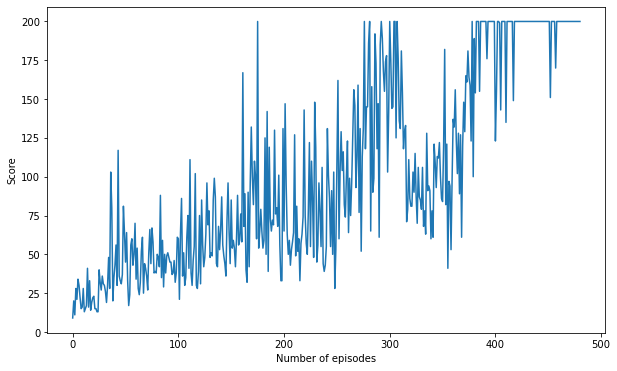

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(10,6)) 
ax.plot(scores)
_ = ax.set(xlabel="Number of episodes", ylabel="Score")

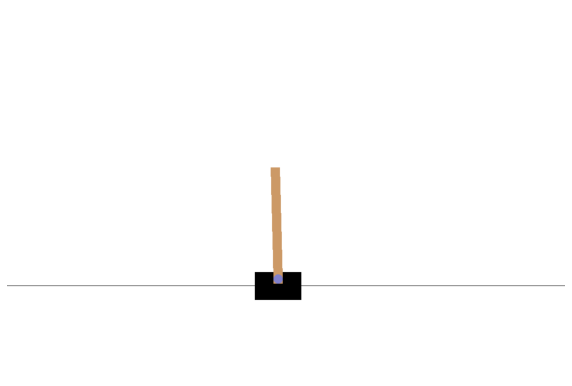

In [153]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
simulate(reinforce_agent, env, ax)

In [157]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

_policy_fn = make_policy_fn(NUMBER_ACTIONS, 16, NUMBER_STATES)

_optimizer_kwargs = {
    "lr": 1e-2,
}

episode_scores = []
number_required_episodes = []
for t in range(100):
    reinforce_agent = ReinforceAgent(_policy_fn,
                                     minibatch_size=1,
                                     optimizer_kwargs=_optimizer_kwargs,
                                     seed=_seed)
    scores = train(reinforce_agent, env, target_score=195.0, number_episodes=1000)
    episode_scores.append(scores)
    number_required_episodes.append(len(scores))


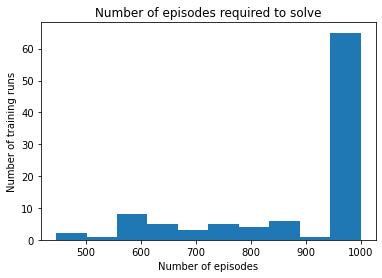

In [165]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(number_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

In [173]:
env = gym.make('CartPole-v0')
env.seed(0)
torch.manual_seed(0) # set random seed

print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = distributions.Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box(4,)
action space: Discrete(2)


In [174]:
def reinforce(env: gym.Env,
              agent_kwargs: dict,
              target_score: float,
              number_episodes: int = 2,
              minibatch_size: int = 5,
              number_iterations: int = 150,
              verbose: bool = False):
    agents = [ReinforceAgent(**agent_kwargs) for _ in range(minibatch_size)]
    scores = []
    most_recent_scores = collections.deque(maxlen=100)
    
    for i in range(number_iterations):
        # train each hillclimber for some number of episodes (this can be done in parallel)
        _ = [train(agents, env, float("inf"), 1, verbose=verbose) for agent in agents]

        average_loss = compute_average_loss(agents)
        
        # if not solved, then synchronize the hill climbers and repeat
        average_score = sum(most_recent_scores) / len(most_recent_scores)
        if len(most_recent_scores) >= 100 and average_score >= target_score:
            if verbose:
                print(f"\nEnvironment solved in {i:d} iterations!\tAverage Score: {average_score:.2f}")
            break
        else:
            synchronize_hillclimbers(hillclimbers, best_hillclimber._best_policy_state_dict)
    
    return scores, best_hillclimber

Episode 100	Average Score: 34.47
Episode 200	Average Score: 66.26
Episode 300	Average Score: 87.82
Episode 400	Average Score: 72.83
Episode 500	Average Score: 172.00
Episode 600	Average Score: 160.65
Episode 700	Average Score: 167.15
Environment solved in 691 episodes!	Average Score: 196.69


In [176]:
_seed = None
env = gym.make('CartPole-v0')
env.seed(_seed)

episode_scores = []
number_required_episodes = []
for t in range(100):
    policy = Policy().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)

    scores = reinforce(print_every=1000)
    episode_scores.append(scores)
    number_required_episodes.append(len(scores))


Episode 1000	Average Score: 124.08
Environment solved in 530 episodes!	Average Score: 195.87
Environment solved in 647 episodes!	Average Score: 195.07
Episode 1000	Average Score: 91.43
Environment solved in 740 episodes!	Average Score: 195.39
Environment solved in 786 episodes!	Average Score: 195.96
Environment solved in 733 episodes!	Average Score: 195.61
Environment solved in 845 episodes!	Average Score: 195.07
Episode 1000	Average Score: 94.45
Environment solved in 776 episodes!	Average Score: 195.22
Episode 1000	Average Score: 80.18
Episode 1000	Average Score: 18.65
Episode 1000	Average Score: 99.22
Episode 1000	Average Score: 77.06
Episode 1000	Average Score: 75.37
Environment solved in 569 episodes!	Average Score: 195.56
Episode 1000	Average Score: 152.69
Episode 1000	Average Score: 67.95
Episode 1000	Average Score: 103.57
Episode 1000	Average Score: 171.31
Environment solved in 800 episodes!	Average Score: 195.64
Episode 1000	Average Score: 81.84
Environment solved in 662 episod

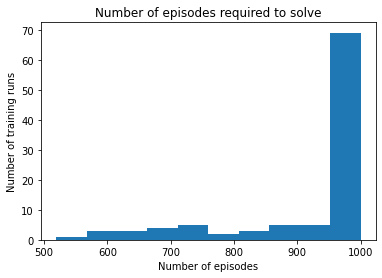

In [177]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(number_required_episodes)
_ = ax.set(xlabel="Number of episodes",
           ylabel="Number of training runs",
           title="Number of episodes required to solve")

## What are the main problems of REINFORCE? There are three issues:

* The update process is very inefficient! We run the policy once, update once, and then throw away the trajectory.

* The gradient estimate gg is very noisy. By chance the collected trajectory may not be representative of the policy.

* There is no clear credit assignment. A trajectory may contain many good/bad actions and whether these actions are reinforced depends only on the final total output.

In the following concepts, we will go over ways to improve the REINFORCE algorithm and resolve all 3 issues. All of the improvements will be utilized and implemented in the PPO algorithm.

## Rewards Normalization

There is another bonus for running multiple trajectories: we can collect all the total rewards and get a sense of how they are distributed.

In many cases, the distribution of rewards shifts as learning happens. Reward = 1 might be really good in the beginning, but really bad after 1000 training episode.

Learning can be improved if we normalize the rewards, where \muμ is the mean, and \sigmaσ the standard deviation.

R_i \leftarrow \frac{R_i -\mu}{\sigma} \qquad \mu = \frac{1}{N}\sum_i^N R_i \qquad \sigma = \sqrt{\frac{1}{N}\sum_i (R_i - \mu)^2}R 
i
​	 ← 
σ
R 
i
​	 −μ
​	 μ= 
N
1
​	  
i
∑
N
​	 R 
i
​	 σ= 
N
1
​	  
i
∑
​	 (R 
i
​	 −μ) 
2
 
​	 

(when all the R_iR 
i
​	  are the same, \sigma =0σ=0, we can set all the normalized rewards to 0 to avoid numerical problems)

This batch-normalization technique is also used in many other problems in AI (e.g. image classification), where normalizing the input can improve learning.

Intuitively, normalizing the rewards roughly corresponds to picking half the actions to encourage/discourage, while also making sure the steps for gradient ascents are not too large/small.